# Exercise 3
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 4 Data Generation with QDA

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]


dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [2]:
# copied from ex02
class QDAClassifier:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

        self.ulabels, counts = np.unique(self.labels, return_counts=True)
        self.filters = [self.labels == l for l in self.ulabels]

        self.filtered_features = [self.features[f] for f in self.filters]

        # mean of D dimensional features for C class labels => CxD
        self.mu = np.stack([np.mean(f, axis=0) for f in self.filtered_features])

        # DxD covariance matrix for the features for C class labels => CxDxD
        self.covmat = np.stack([np.cov(f, rowvar=False) for f in self.filtered_features])
        
        """ singular matrices...
        # precompute the inverse matrices and determinants
        self.icovmat = np.stack([np.linalg.inv(c) for c in self.covmat])
        # since covmats are always square, we can factor out the 2 * pi
        self.covdets = np.stack([(2 * np.pi) ** c.shape[0] * np.linalg.det(c) for c in self.covmat])
        """
        # prior probabilities tell how often each class occurs => Cx1
        self.p = counts / len(self.labels)

    def fit(self):
        return self.mu, self.covmat, self.p

    def _b(self):
        return 0.5 * np.log(self.covdets) - np.log(self.p)

    def _mahalanobis(self, data):
        diff = data[:,np.newaxis,:] - self.mu[np.newaxis,:,:]

        prod = (diff[:,:,np.newaxis,:] * self.icovmat).sum(axis=3)
        return (prod * diff).sum(axis=2)

    def _distances(self, data):
        """ Squared Mahalanobis Distance """
        return self._mahalanobis(data) + self._b()


    def predict(self, data):
        return np.argmin(self._distances(data), axis=-1)

    def score(self, X_test, Y_test):
        predicted = self.predict(X_test)
        return 1 - (np.mean((predicted == 0) != (Y_test == 1)))

    def mvgauss(self, data):
        return np.exp(self._mahalanobis(data)) / np.sqrt(self.covdets)

    def get_params(self, deep=False):
        return {"mu": self.mu, "covmat": self.covmat, "p": self.p}



qda = QDAClassifier(data, target)

mu, covmat, p = qda.fit()

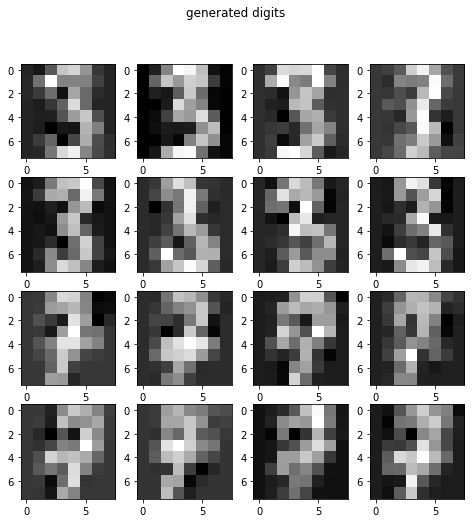

In [3]:
digits = [3,7]
fig, axs = plt.subplots(2*len(digits), 4, figsize=(8, 8))
fig.suptitle("generated digits")

for i, d in enumerate(digits):
    out = np.random.multivariate_normal(mu[d], covmat[d], size=(8))
    for j, image_data in enumerate(out):

        axs[j//4+2*i, j%4].imshow(np.reshape(image_data, (-1, 8)), cmap="gray")

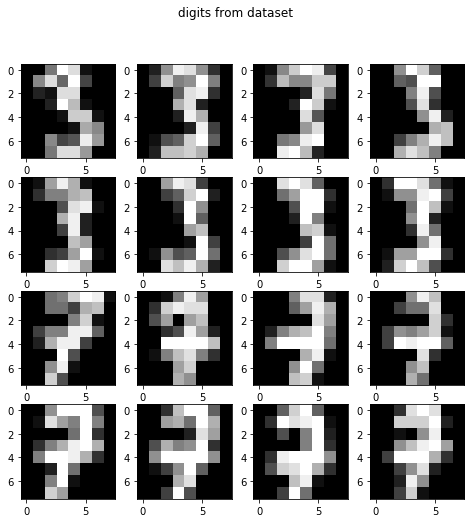

In [4]:
# for comparison
fig, axs = plt.subplots(2*len(digits), 4, figsize=(8, 8))
fig.suptitle("digits from dataset")
for i, d in enumerate(digits):
    out = data[target == d][:8]
    for j, image_data in enumerate(out):
        axs[j//4+2*i, j%4].imshow(np.reshape(image_data, (-1, 8)), cmap="gray")

The digits from the generated images are well recognizable but they are a bit blurry